In [137]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, ncx2, chi2
from six.moves import reload_module

import GPy
from GPy.models import GPRegression

from emukit.experimental_design.model_free.random_design import RandomDesign
from emukit.experimental_design.model_free.latin_design import LatinDesign
from emukit.model_wrappers import GPyModelWrapper
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.bayesian_optimization.acquisitions \
    import ExpectedImprovement as ExpectedImprovement_std

import sys
sys.path.append("..")
from l2_bayes_opt.l2_acquisitions.expected_improvement \
    import ExpectedImprovement as ExpectedImprovement_L2

In [11]:
from scipy.stats import multivariate_normal as mvn, ncx2
from l2_bayes_opt.chi_statistics import norm_dist

def plot_approx(mean, std, target, d_min, pdf_approx=None, cdf_approx=None,
                ppf_approx=None):
    if pdf_approx is None:
        pdf_approx = ncx2.pdf
    if cdf_approx is None:
        cdf_approx = lambda a, b, c: norm_dist._ncx2_cdf(a, b, c, False)
    if cdf_approx is None:
        cdf_approx = lambda q, k, nc: norm_dist._ncx2_ppf(0, np.sqrt(nc), c, d, False)

    k = len(mean)

    # Draw samples from normal distribution
    X = mvn.rvs(mean=mean, cov=np.diag(std**2), size=3000)
    if X.ndim == 1:
        X = X[:, None]

    # Calculate the samples' distances to target
    d = ((X - target)**2).sum(axis=1)

    # Plot emperical density and cumulative distribution
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    hist, edges = np.histogram(d, bins=300, density=True)
    bin_width = np.diff(edges).mean()
    r = edges[:-1]+bin_width/2

    ax1.bar(r, hist, width=bin_width)
    ax2.bar(r, hist.cumsum()*bin_width, width=bin_width)

    # Plot approximated distribution over distance
    gamma2 = (std**2).mean()
    nc = ((mean - target)**2).sum()/gamma2
    ncx2_pdf = pdf_approx(r/gamma2, k, nc)/gamma2
    ncx2_cdf = cdf_approx(r/gamma2, k, nc)
    
    qs = tuple(np.linspace(0, 1, 11))
    ppfs_emp = np.percentile(d, qs)
    

    ax1.plot(r, ncx2_pdf, "r")
    ax2.plot(r, ncx2_cdf, 'r')

    # Get emperical expected improvement
    d[d >= d_min] = d_min
    ei_emp = (d_min - d).mean()
    
    # Calculate analytical expected improvement
    def h(k_):
        return cdf_approx(d_min / gamma2, k_, nc)
    t1 = d_min * cdf_approx(d_min / gamma2, k, nc)
    t2 = gamma2 * (k * h(k + 2) + nc * h(k + 4))
    ei_calc = t1 - t2

    # Plot expected improvement
    for ax in (ax1, ax2):
        ax.axvline(x=d_min, color="y", linestyle=":", label="d_min")
        ax.axvline(x=d_min-ei_calc, color="r", linestyle="--", label="Calc. EI")
        ax.axvline(x=d_min-ei_emp, color="g", linestyle=":", label="Emp. EI")
        ax.set_xlim(0, None)
        ax.legend()
    
    fig.suptitle("Calculated EI: {:.2e}\nEmperical EI: {:.2e}".format(ei_calc, ei_emp))

In [114]:
def get_emperical_error(mean, std, target, d_min, cdf_approx):
    # Draw samples from normal distribution
    X = mvn.rvs(mean=mean, cov=np.diag(std**2), size=3000)
    if X.ndim == 1:
        X = X[:, None]

    # Calculate the samples' distances to target
    d = ((X - target)**2).sum(axis=1)

    # Plot emperical density and cumulative distribution
    hist, edges = np.histogram(d, bins=300, density=True)
    bin_width = np.diff(edges).mean()
    r = edges[:-1]+bin_width/2
    cdf_emp = hist.cumsum()*bin_width
    
    k = len(mean)
    gamma2 = (std**2).mean()
    nc = ((mean - target)**2).sum()/gamma2
    cdf_calc = cdf_approx(r/gamma2, k, nc)
    cdf_err = np.sqrt(((cdf_emp-cdf_calc)**2).sum())
    
    return cdf_err

In [239]:
1 + h*p*(h - 1 - 0.5*(2 - h)*m_*p), 1 + m*(m - 1)*r2/(2*r1**2) - m*(m - 1)*(2 - m)*(1 - 3*m)*r2**2/(8*r1**4)

(0.9268100740740741, 0.9268100740740741)

In [237]:
g2, alpha

(0.9268100740740741, 0.5905026199703705)

In [240]:
k = 2
nc = 4
x = 2

h = 1-2./3*(k+nc)*(k+3*nc)/(k+2*nc)**2
p = (k + 2*nc)/(k + nc)**2
m_ = (h - 1)*(1 - 3*h)

g1 = (x/(k + nc))**h
g2 = 1 + h*p*(h - 1 - 0.5*(2 - h)*m_*p)
g3 = h*np.sqrt(2*p)*(1 + 0.5*m_*p)

res1 = norm.cdf((g1 - g2)/g3)

r1 = k + nc
r2 = 2*(k + 2*nc)
r3 = 4*2*(k + 3*nc)

m = 1 - r1*r3/(3*r2**2)
z = (x/(k + nc))**m
alpha = 1 + m*(m - 1)*r2/(2*r1**2) - m*(m - 1)*(2 - m)*(1 - 3*m)*r2**2/(8*r1**4)
rho = m*np.sqrt(r2)/r1 * (1 - (1 - m)*(1 - 3*m)/(4*r1**2)*r2)
res2 = norm.cdf((z - alpha)/rho)

print("Res 1: {:.2e}".format(res1))
print("Res 2: {:.2e}".format(res2))

Res 1: 1.78e-01
Res 2: 1.78e-01


In [258]:
def paper_cdf(t, k, nc):
    r1 = k + nc
    r2 = 2*(k + 2*nc)
    r3 = 4*2*(k + 3*nc)

    m = 1 - r1*r3/(3*r2**2)
    z = (t/(k + nc))**m
    alpha = 1 + m*(m - 1)*(r2/(2*r1**2) - (2 - m)*(1 - 3*m)*r2**2/(8*r1**4))
    rho = m*np.sqrt(r2)/r1 * (1 - (1 - m)*(1 - 3*m)/(4*r1**2)*r2)
    return norm.cdf((z - alpha)/rho)

def paper_ppf(beta, k, nc):
    r1 = k + nc
    r2 = 2*(k + 2*nc)
    r3 = 4*2*(k + 3*nc)

    m = 1 - r1*r3/(3*r2**2)
    z = (t/(k + nc))**m
    alpha = 1 + m*(m - 1)*r2/(2*r1**2) - m*(m - 1)*(2 - m)*(1 - 3*m)*r2**2/(8*r1**4)
    rho = m*np.sqrt(r2)/r1 * (1 - (1 - m)*(1 - 3*m)/(4*r1**2)*r2)

def new_cdf1(t, k, nc):
    return chi2.cdf(t/(1 + nc/k), df=k)

def new_ppf1(q, k, nc):
    return chi2.ppf(q, df=k)*(1 + nc/k)

def new_cdf2(t, k, nc):
    rho2 = nc
    rho = np.sqrt(nc)
    r = np.sqrt(t)
    p = k
    z = (r - rho) - (p - 1)/2. * (np.log(r) - np.log(rho))/(r - rho)
    return norm.cdf(z)

In [260]:
k = 2
mean = (np.random.random((k,))-0.5) * 2
std = (np.random.random((k,))+1) * 1
target = (np.random.random((k,))-0.5) * 2
d_min = 2*((mean - target)**2).sum()

''

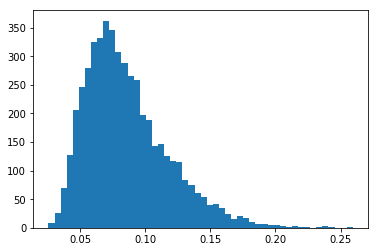

In [261]:
errs = [get_emperical_error(mean, std, target, d_min, paper_cdf)
        for _ in range(5000)]
plt.hist(errs, bins="auto")
;

''

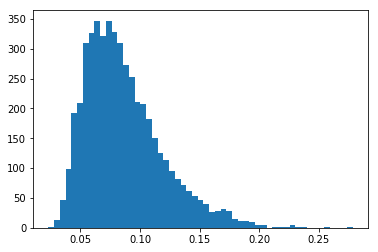

In [262]:
errs = [get_emperical_error(mean, std, target, d_min, paper_cdf)
        for _ in range(5000)]
plt.hist(errs, bins="auto")
;

''

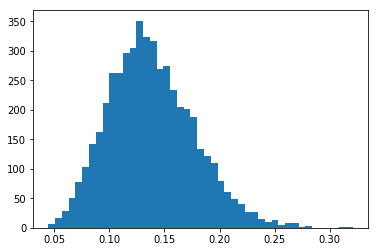

In [249]:
errs = [get_emperical_error(mean, std, target, d_min, ncx2.cdf)
        for _ in range(5000)]
plt.hist(errs, bins="auto")
;

''

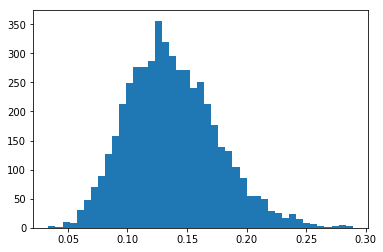

In [250]:
errs = [get_emperical_error(mean, std, target, d_min, norm_dist._ncx2_cdf)
        for _ in range(5000)]
plt.hist(errs, bins="auto")
;

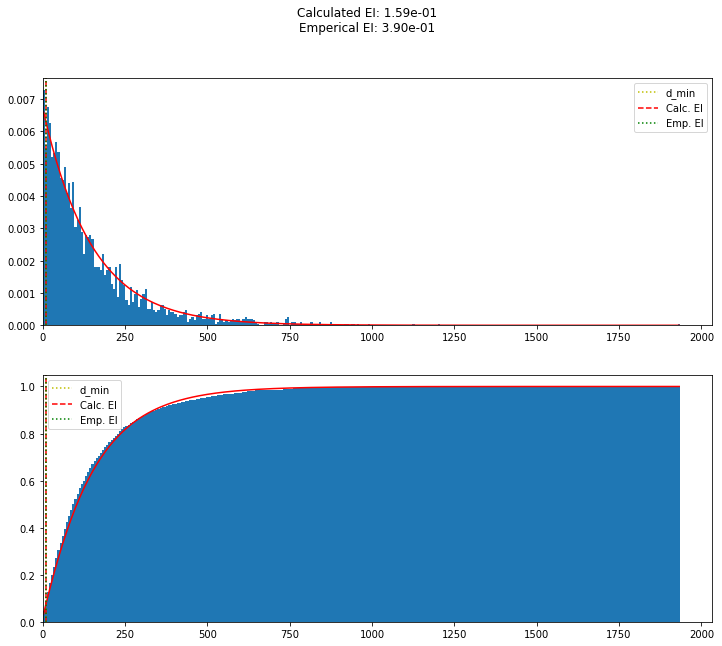

In [256]:
plot_approx(mean, std, target, d_min, cdf_approx=paper_cdf)

# Analysis of variance

In [17]:
def norm_ei(m, s, f_min, jitter=0):
    from GPyOpt.util.general import get_quantiles
    pdf, cdf, u = get_quantiles(jitter, f_min, m, s)
    return s * (u * cdf + pdf)

def l2_ei(m, s, f_min):
    k = m.shape[-1]
    sigma_hat2 = (s**2).mean(axis=1)
    sigma_hat = np.sqrt(sigma_hat2)
    alphas = m / sigma_hat[:, None]
    nc = (alphas**2).sum(axis=1)

    def h(k_):
        return norm_dist._ncx2_cdf(f_min / sigma_hat2, k_, nc)

    t1 = f_min * norm_dist._ncx2_cdf(f_min / sigma_hat2, k, nc)
    t2 = sigma_hat2 * (k * h(k + 2) + nc * h(k + 4))

    res = t1 - t2
    return np.clip(t1 - t2, 0, None)[:, None]

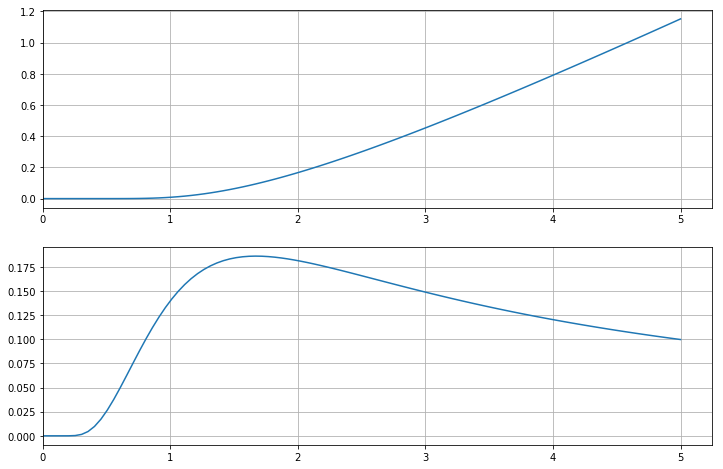

In [18]:
fig, (ax_norm, ax_l2) = plt.subplots(2, 1, figsize=(12, 8))

std_range = np.linspace(0.001, 5, 100)[:, None]
mean = np.ones_like(std_range)*3
f_min = 1

norm_util = norm_ei(mean, std_range, f_min)
l2_util = l2_ei(np.sqrt(mean), std_range, f_min)

ax_norm.plot(std_range.ravel(), norm_util)
ax_l2.plot(std_range.ravel(), l2_util)

for ax in (ax_norm, ax_l2):
    ax.set_xlim(0, None)
    ax.grid()